In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append("..") # Adds higher directory to python modules path.


import seaborn as sns
import matplotlib

plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
from StocksDataWrapper import *
from DataHelper import *
from Plots import *

In [3]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'IBM'
price_column = 'Close'
project_label='KerasLSTMRegression'

predict_n = 10

In [4]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", 
                                           compute_features=True, predict_n=predict_n, normalize=True)

data_wrapper.head()

Date      Open      High       Low     Close  Adjusted    Volume  \
0  1962-03-21  0.015428  0.014523  0.015787  0.015429  0.005020  0.003780   
1  1962-03-22  0.015334  0.014334  0.015533  0.015051  0.004897  0.003456   
2  1962-03-23  0.015113  0.014271  0.015565  0.015177  0.004938  0.002700   
3  1962-03-26  0.015207  0.014334  0.015597  0.015162  0.004933  0.001944   
4  1962-03-27  0.015113  0.014114  0.014963  0.014516  0.004723  0.005076   

     LowLen   RSI(14)       GAP  ...   SMA(10)   SMA(20)   EMA(14)  EMA_Diff  \
0  0.002525  0.595025  0.000000  ...  0.014503  0.013555  0.013679  0.619962   
1  0.000000  0.456905  0.001641  ...  0.014474  0.013587  0.013637  0.619512   
2  0.000000  0.505305  0.000410  ...  0.014436  0.013619  0.013618  0.619054   
3  0.001263  0.499957  0.000000  ...  0.014399  0.013656  0.013600  0.618669   
4  0.000842  0.332912  0.001026  ...  0.014300  0.013658  0.013496  0.617898   

   SMA(20) - SMA(10)  Difference  PercentageDiff  Tendency  NextPrice    Next  
0           0.394439    0.596761        0.496869    higher   0.012863   lower  
1           0.394997    0.595125        0.477865     lower   0.013540  higher  
2           0.395653    0.594787        0.474037    higher   0.013508   lower  
3           0.396346    0.594843        0.474674     lower   0.013540  higher  
4           0.397285    0.592643        0.449242     lower   0.013666  higher  

[5 rows x 32 columns]

In [5]:
y_column = 'NextPrice'
seq_len = 5
features = ['Close', 'Volume', 'MACD_diff', 'RSI(14)', 'PercentageDiff', 'LowLen', 'RSI_diff']
datasets_splits = data_wrapper.get_datasets(n_splits=10, val_size=0.2, sequences=True, seq_len=10, y_column=y_column, features_list=features)

datasets_splits.shape

(10, 6)

https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [6]:
import tensorflow as tf

def build_model(inputs, learning_rate, loss):
    inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
    lstm_out = keras.layers.LSTM(50)(inputs)
    dense_1 = keras.layers.Dense(8)(lstm_out)
    outputs = keras.layers.Dense(1)(dense_1)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=loss)
    return model



In [7]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [8]:
from sklearn.metrics import mean_squared_error
def test_model(model, test_set):
    predictions = np.array([])
    labels = np.array([])

    for x, y in test_set:
        predictions = np.concatenate([predictions, model.predict(x).flatten()])
        labels = np.concatenate([labels,y])
    
    print(f"MSE : {mean_squared_error(y_pred=predictions, y_true=labels)}")
    
    test_df = pd.DataFrame(data={'Close':predictions})
    scaled_preds = data_wrapper.get_unscaled_data(df=test_df)['Close']
    test_df = pd.DataFrame(data={'Close':labels})
    scaled_labels = data_wrapper.get_unscaled_data(df=test_df)['Close']
    
    ax = plt.gca()
    ax.plot(scaled_preds, label="Predictions")
    ax.plot(scaled_labels, label="True prices")
    plt.title("Prices predictions and true values")
    plt.ylabel("Price (USD)")
    plt.legend(loc='best')
    plt.show()

0it [00:00, ?it/s]

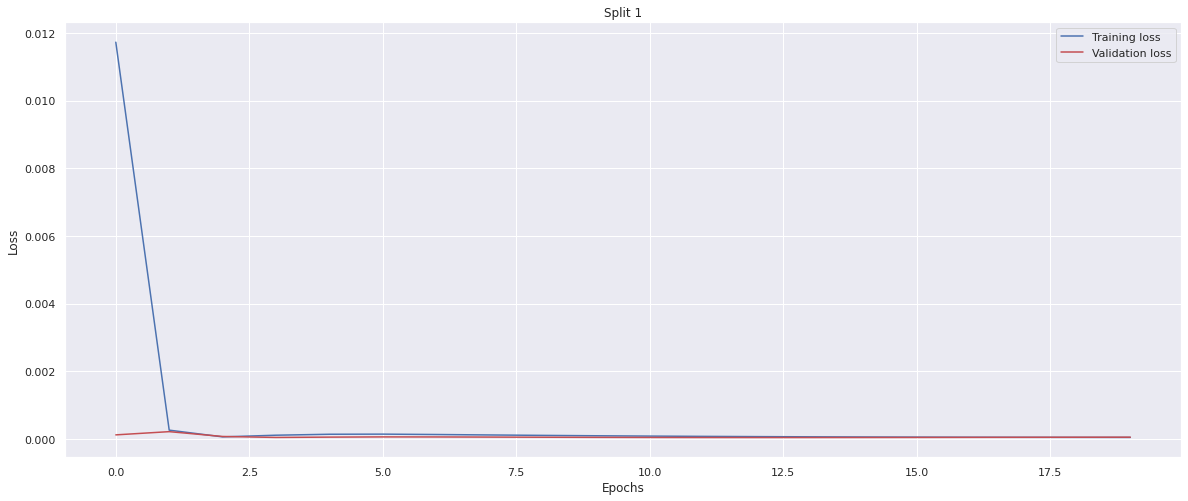

MSE : 5.141280432487247e-05


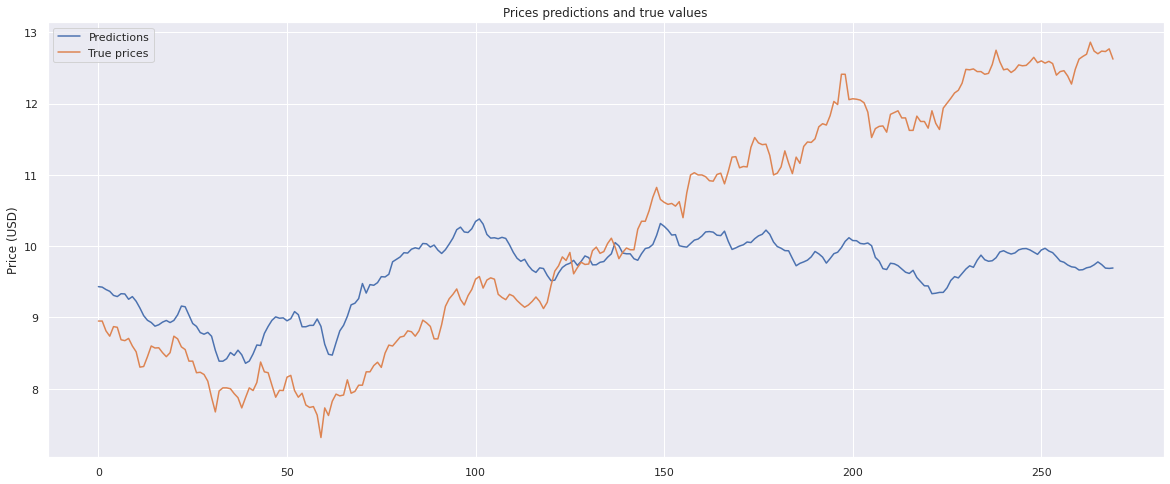

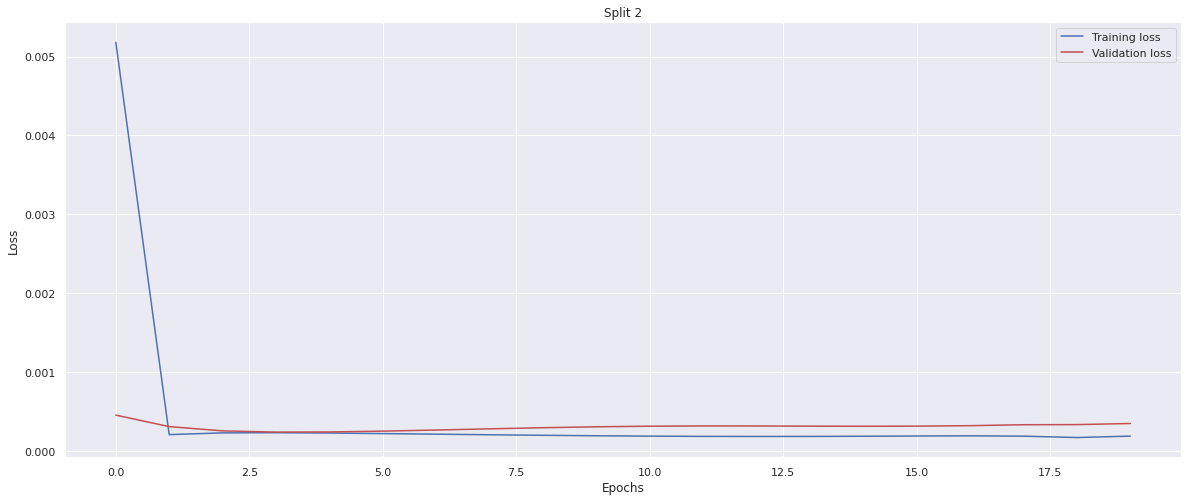

MSE : 0.0003473184059924744


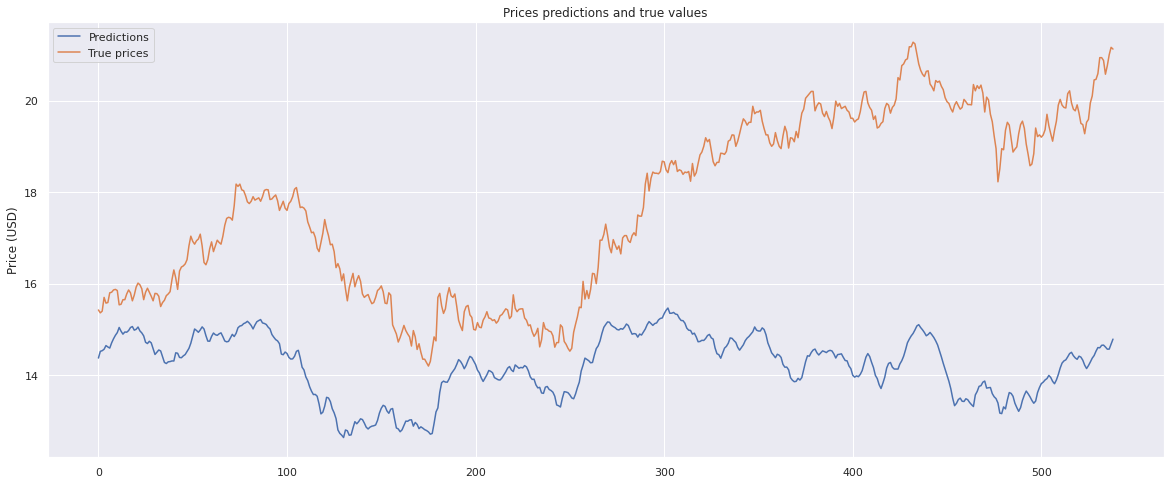

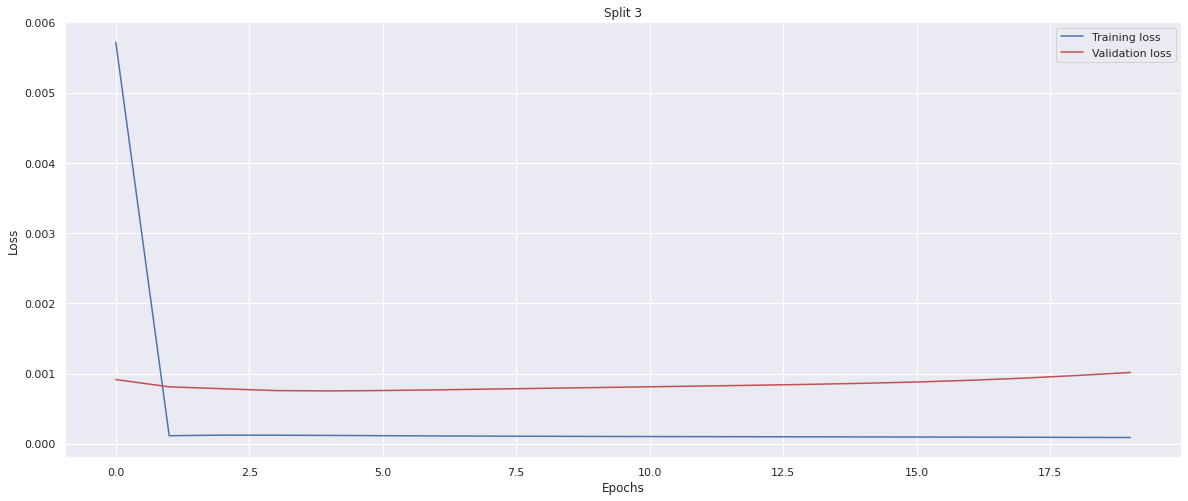

MSE : 0.0010153081747443593


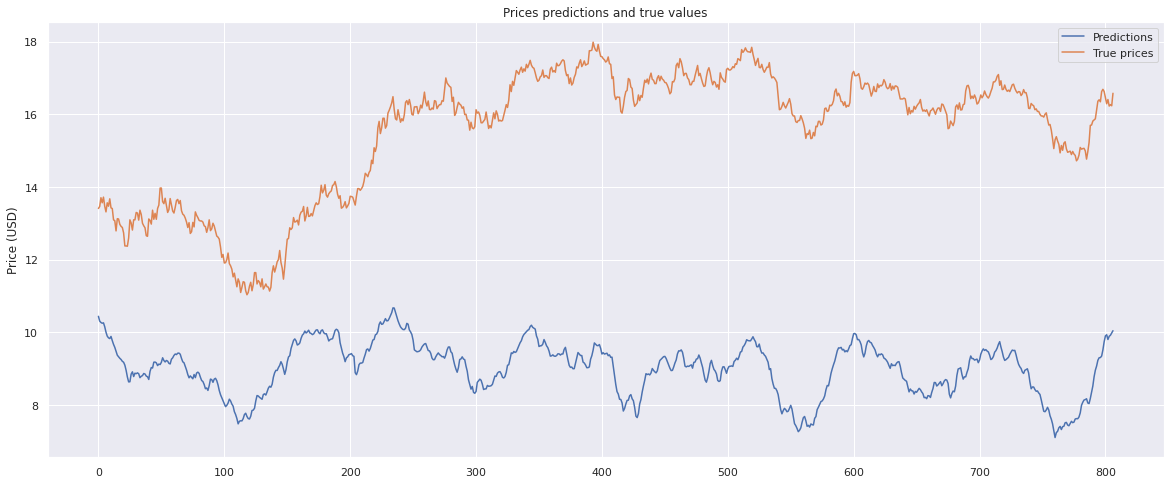

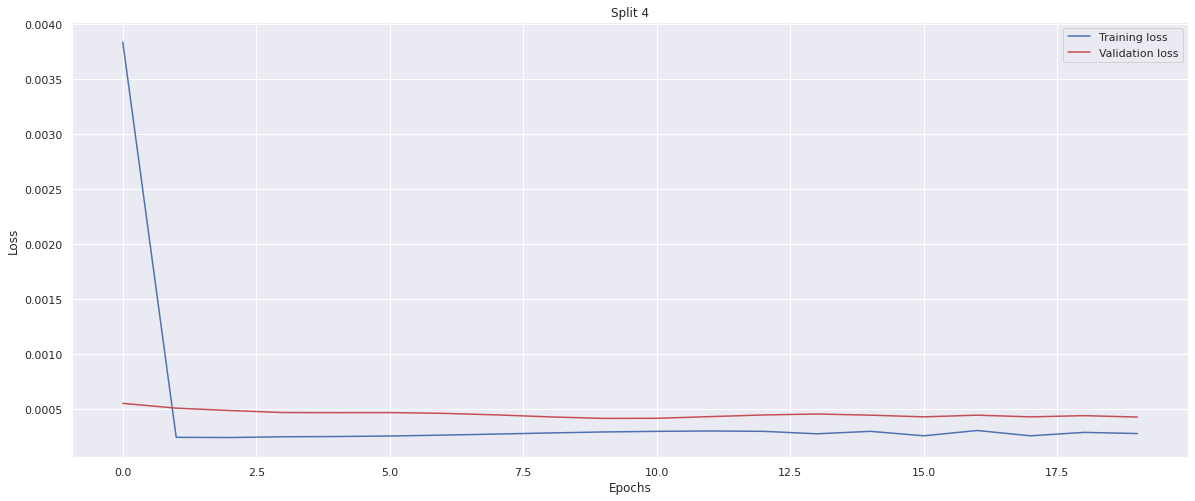

MSE : 0.00042483012808474687


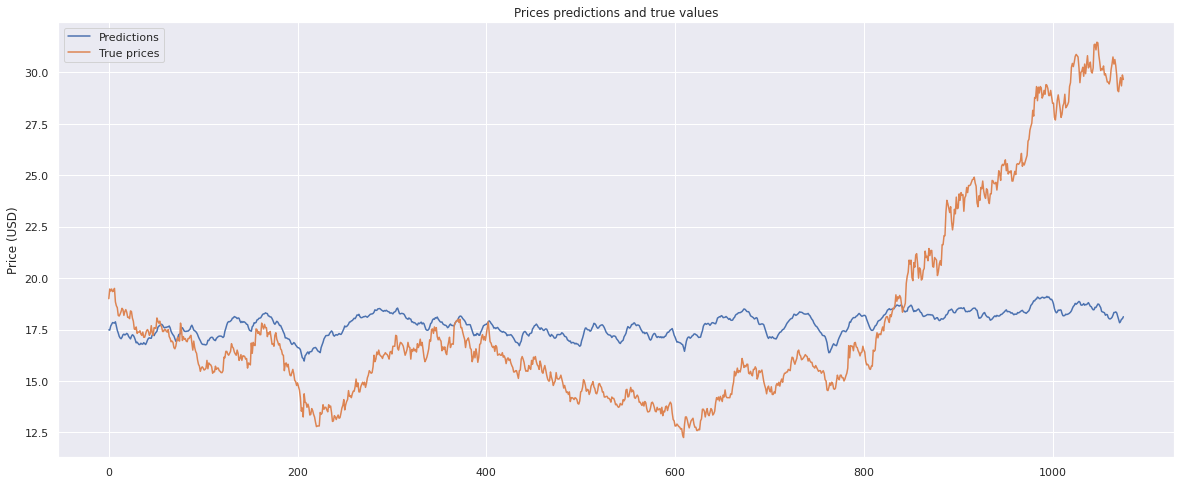

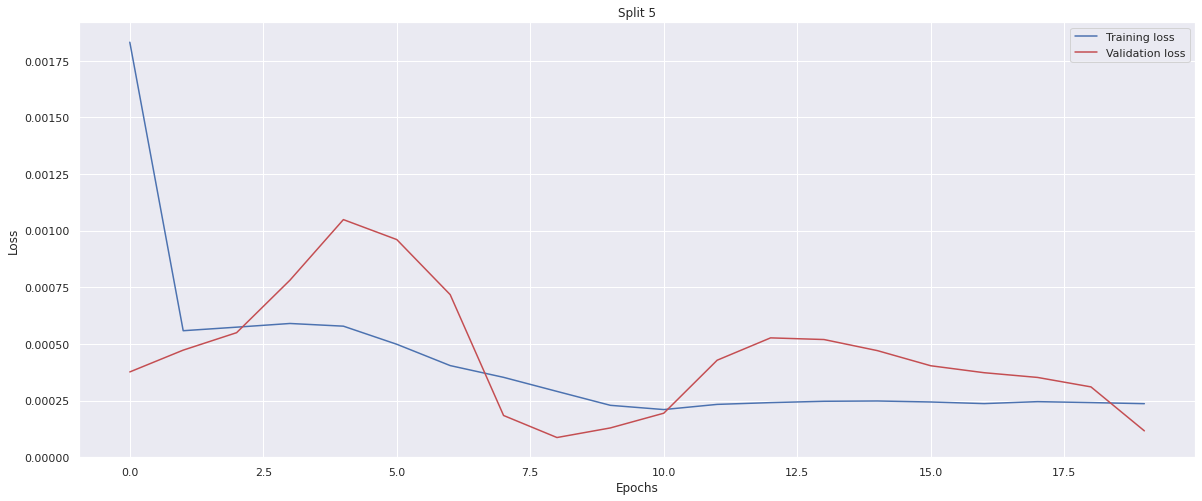

MSE : 0.00011650104227015526


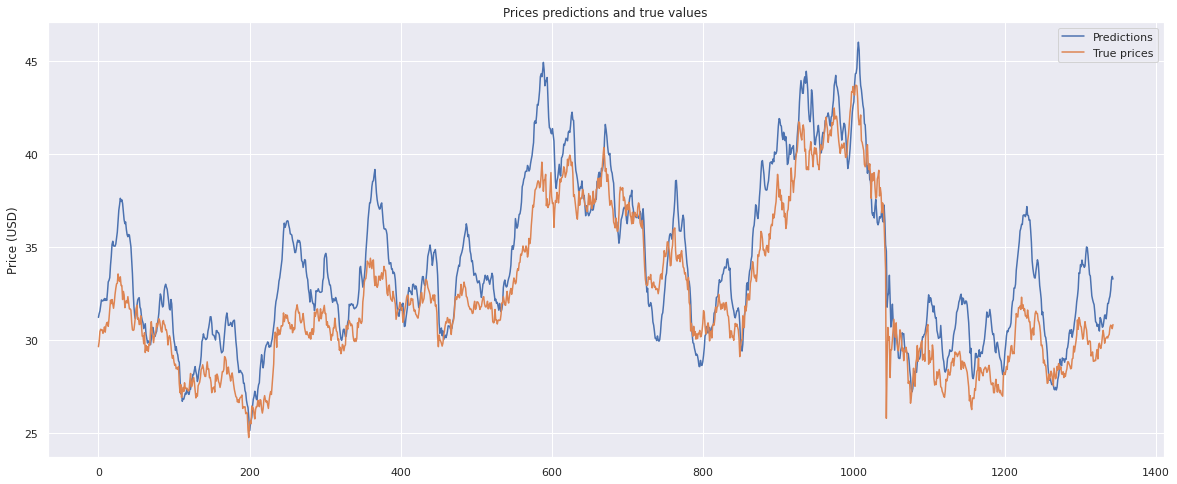

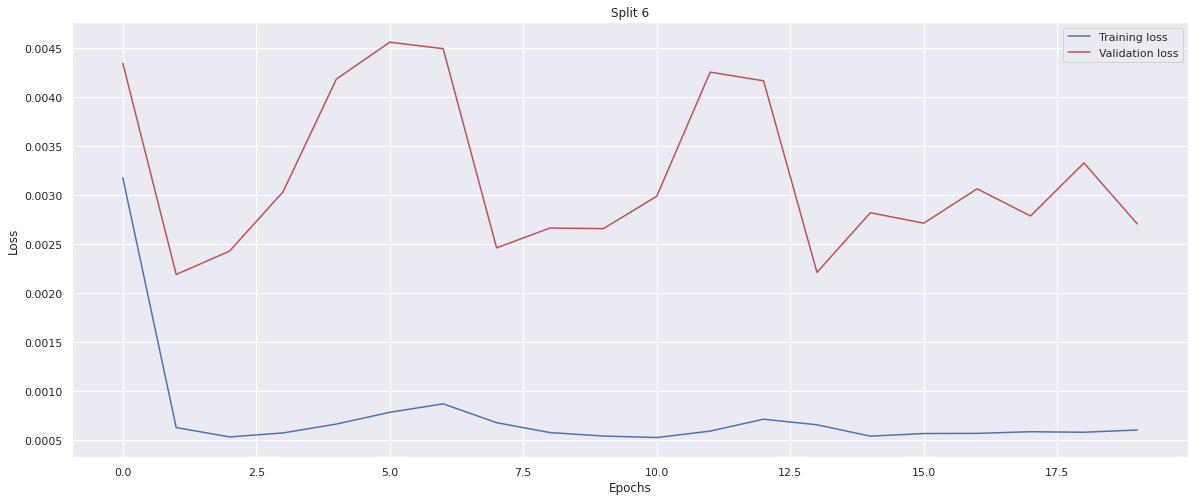

MSE : 0.0027026661974111233


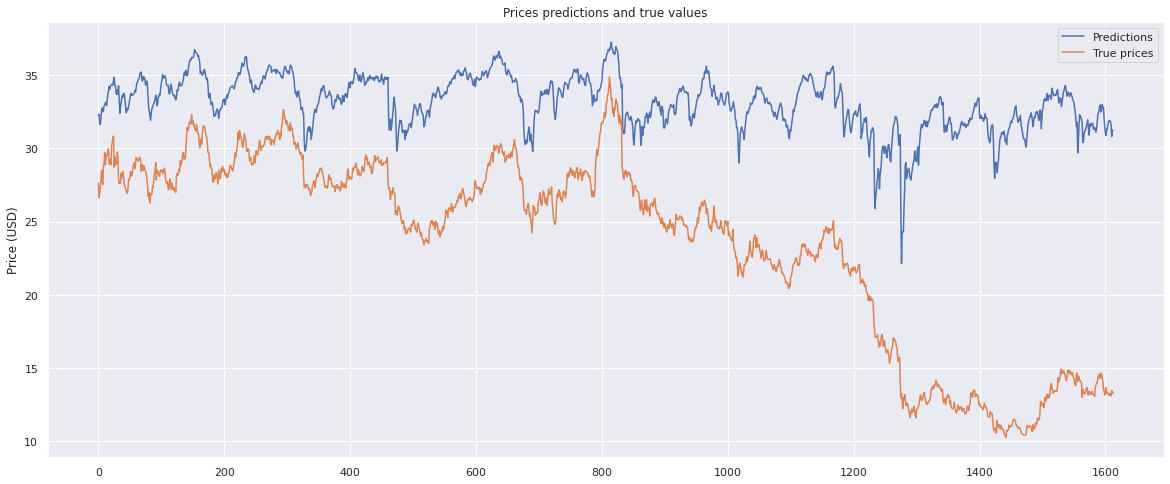

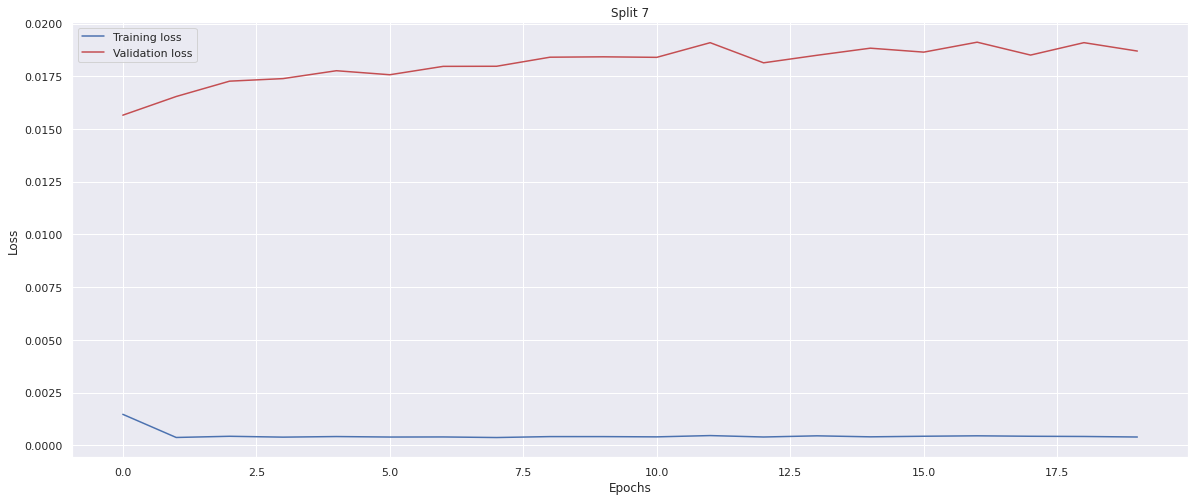

MSE : 0.018695872728278082


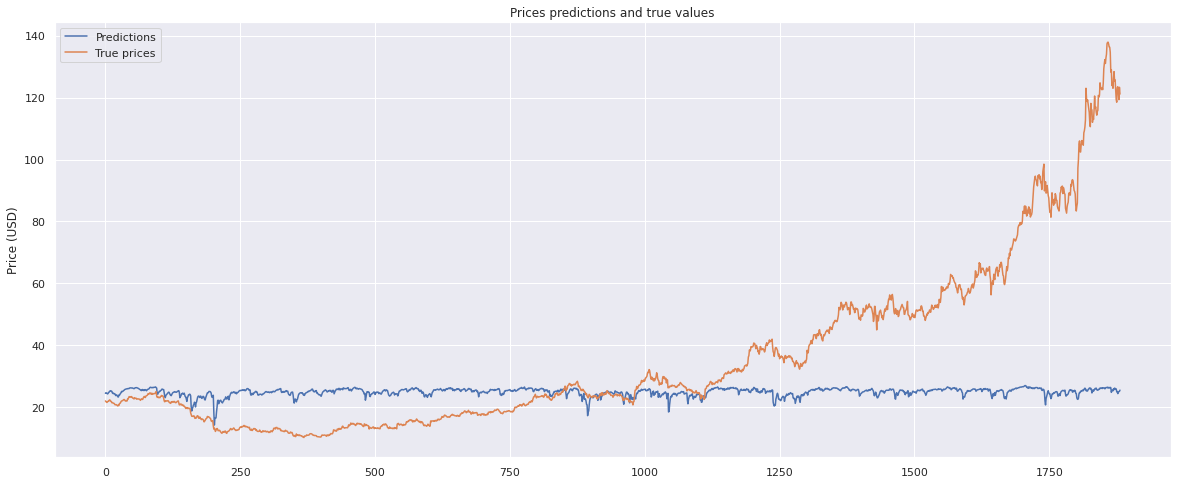

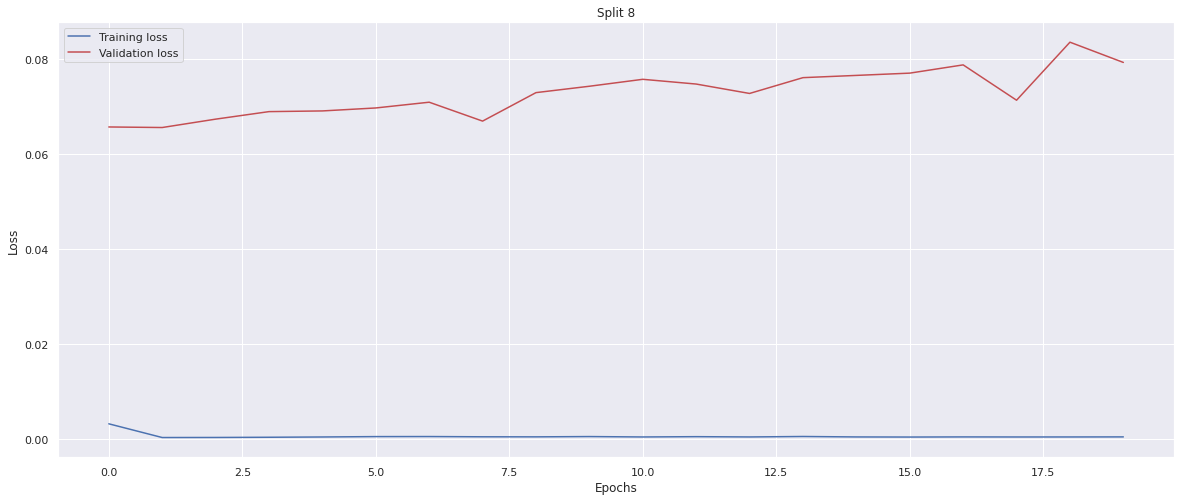

MSE : 0.07927851116494136


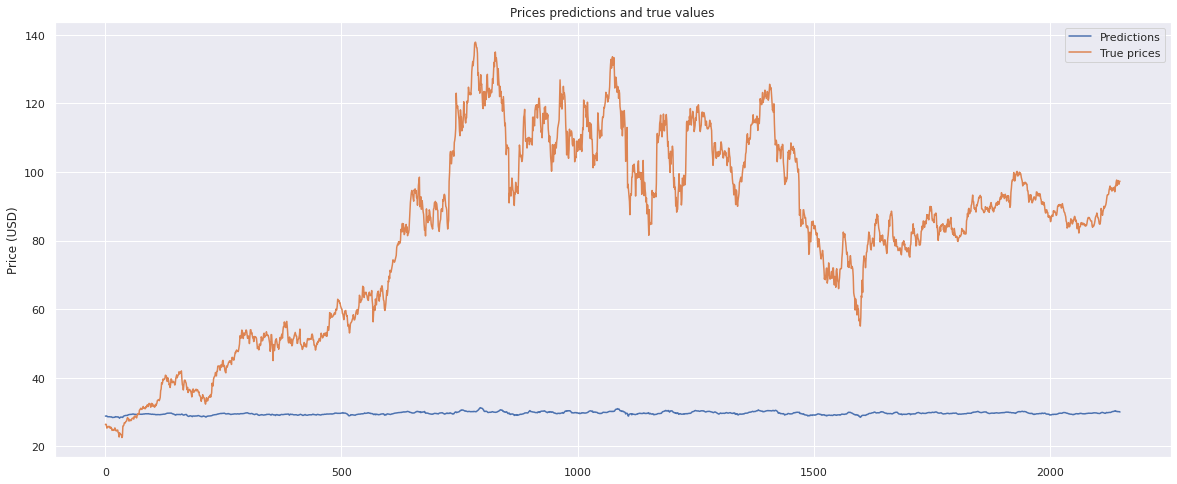

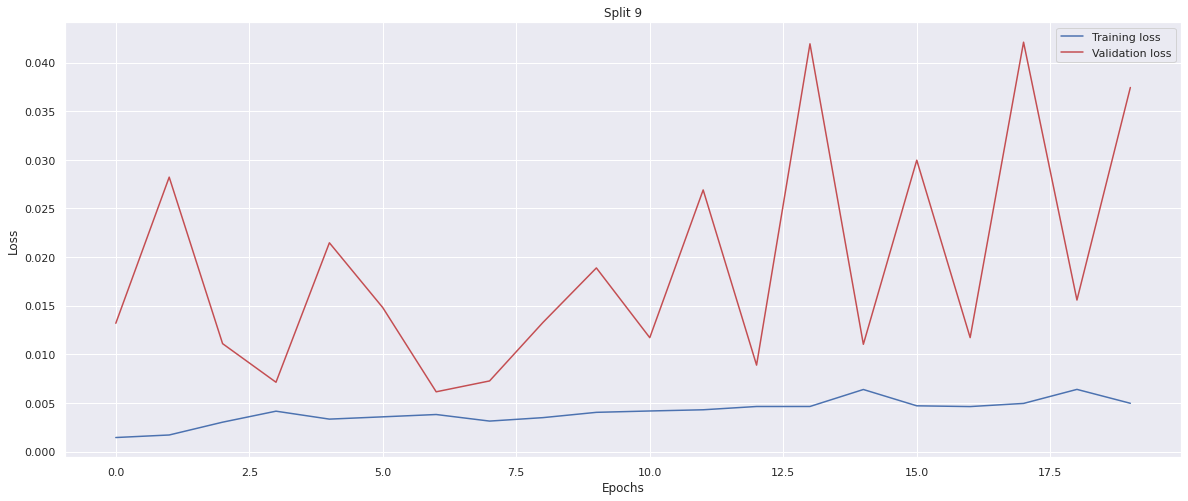

MSE : 0.03742991318049859


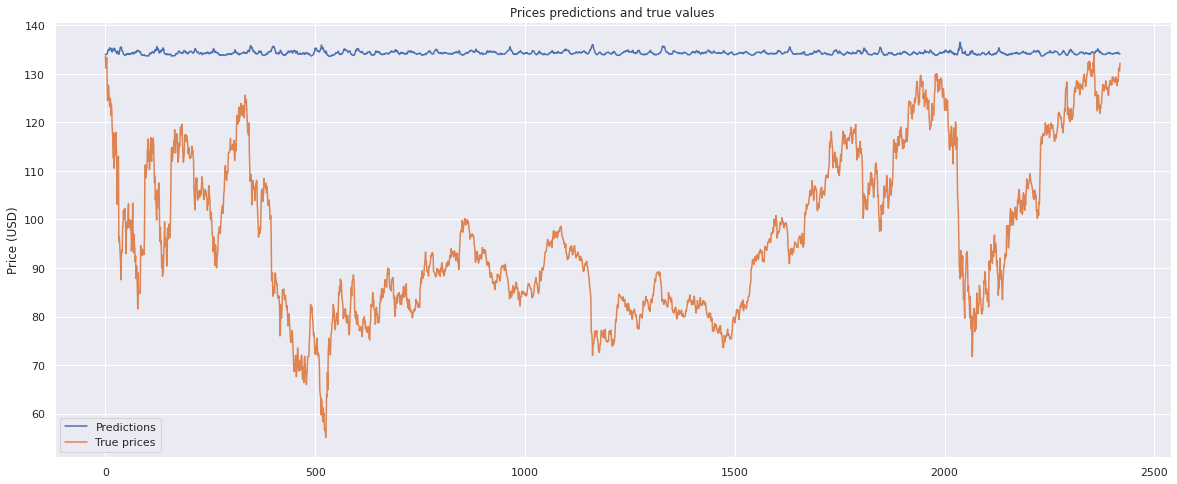

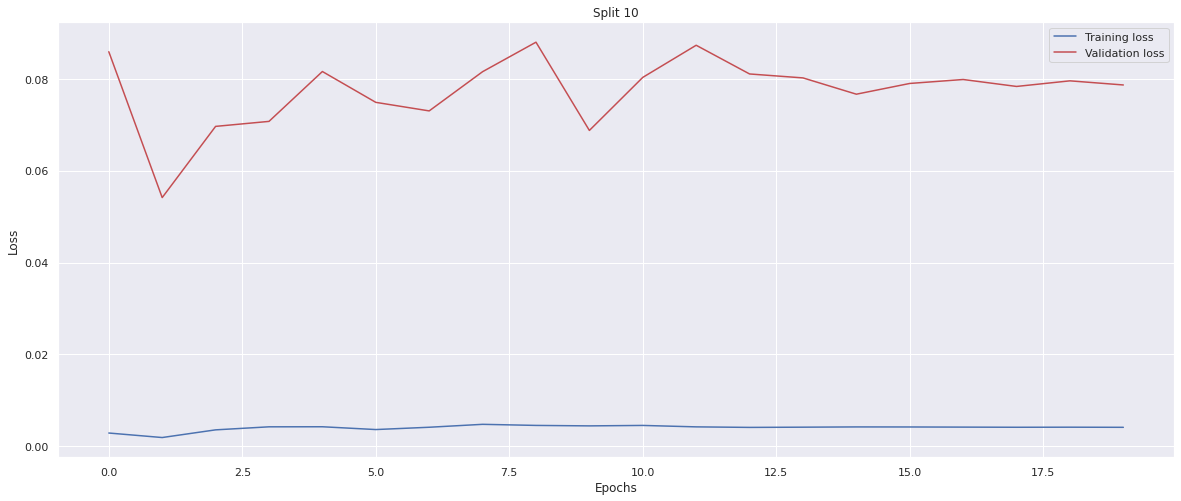

MSE : 0.07867628672329363


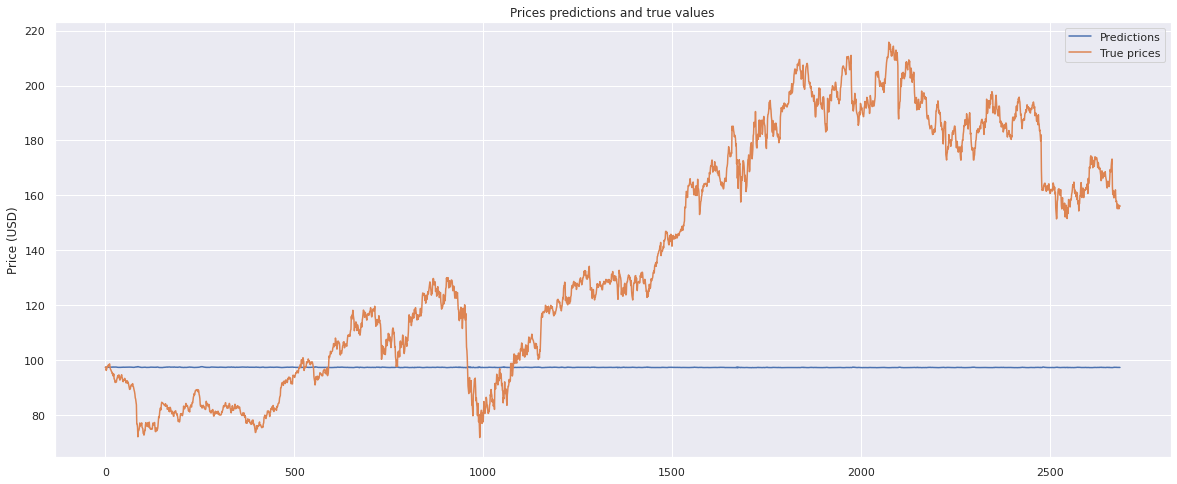

In [9]:
from keras.preprocessing import timeseries_dataset_from_array as build_timeseries_ds

learning_rate = 0.01
loss = 'mse'
batch_size = 32
n_epochs=20

for split_id, split in tqdm(enumerate(datasets_splits)):
    (X_train, X_val, X_test, y_train, y_val, y_test) = split

    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
    test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

    for batch in train_set.take(1):
        inputs, targets = batch
        
    
    model = build_model(inputs, learning_rate=learning_rate, loss=loss)
    history = model.fit(train_set, validation_data=val_set, epochs=n_epochs, shuffle=False, verbose=0)
    visualize_loss(history, f"Split {split_id+1}")
    #print(f"Loss : {history.history['val_loss']}")
    test_model(model, val_set)

In [13]:
import lime
from lime import lime_tabular

# https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
training_samples = np.concatenate([x for x, y in train_set], axis=0)
training_labels = np.concatenate([y for x, y in train_set], axis=0)

explainer = lime_tabular.RecurrentTabularExplainer(inputs, training_labels=targets,
                                                   discretize_continuous = True,
                                                   feature_names=X_train,
                                                   verbose=True, mode='regression')

In [15]:
test_samples = np.concatenate([x for x, y in val_set], axis=0)

print(test_samples.shape)

(2687, 10, 7)


In [16]:
# https://github.com/marcotcr/lime/blob/master/doc/notebooks/Submodular%20Pick%20examples.ipynb

import warnings
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(explainer, training_samples, model.predict, 
                                        sample_size=15, num_features=10, num_exps_desired=5)

Intercept 0.4414837183133796
Prediction_local [0.44174785]
Right: 0.44141412
Intercept 0.4416258182894812
Prediction_local [0.44128737]
Right: 0.44069645
Intercept 0.4417464680061618
Prediction_local [0.44092101]
Right: 0.4403354
Intercept 0.44169122427863505
Prediction_local [0.44112884]
Right: 0.44059652
Intercept 0.44174787030548746
Prediction_local [0.4409412]
Right: 0.4402799
Intercept 0.4415734061655106
Prediction_local [0.44146027]
Right: 0.4412917
Intercept 0.44158868125674505
Prediction_local [0.44144286]
Right: 0.44135362
Intercept 0.4414361556784935
Prediction_local [0.44187821]
Right: 0.4411105
Intercept 0.44160226610103653
Prediction_local [0.44139051]
Right: 0.4413398
Intercept 0.441626842767252
Prediction_local [0.44127313]
Right: 0.44112736
Intercept 0.4416425259916174
Prediction_local [0.44129794]
Right: 0.44109178
Intercept 0.4415144927908363
Prediction_local [0.44164651]
Right: 0.44160357
Intercept 0.44176059502681614
Prediction_local [0.44090936]
Right: 0.44067472
I

[<Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>]

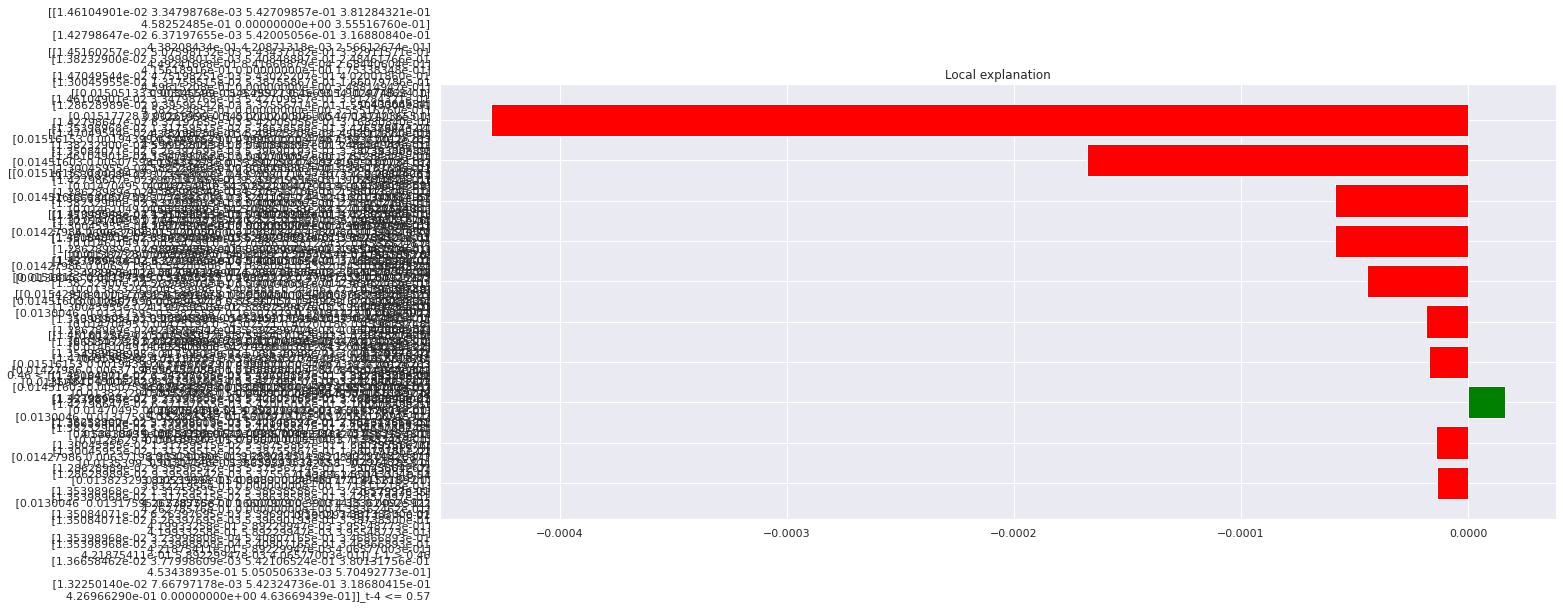

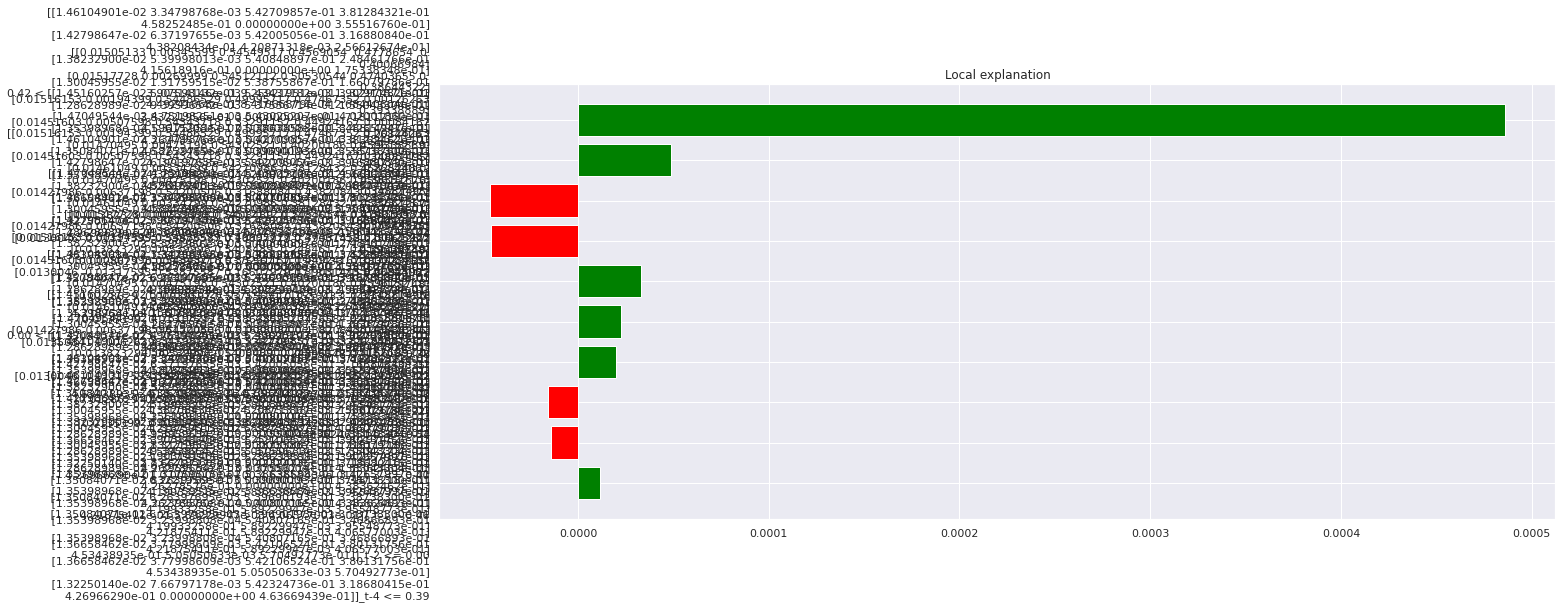

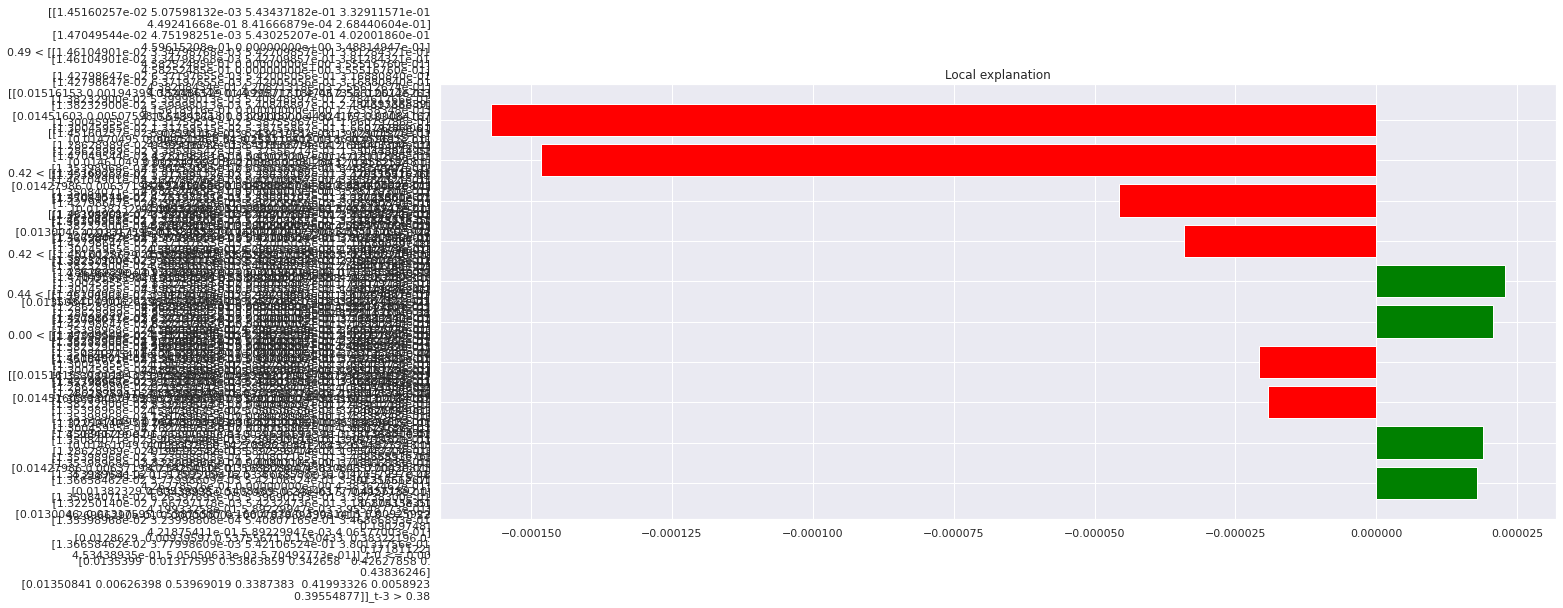

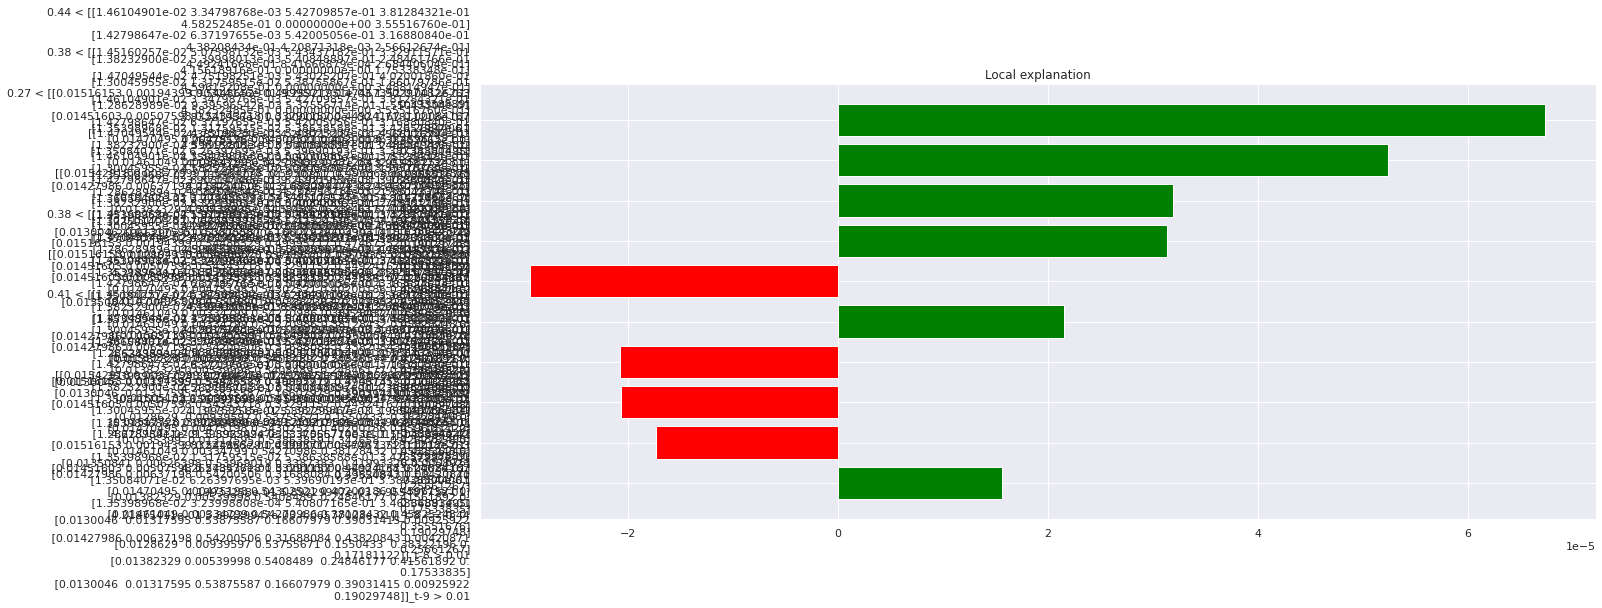

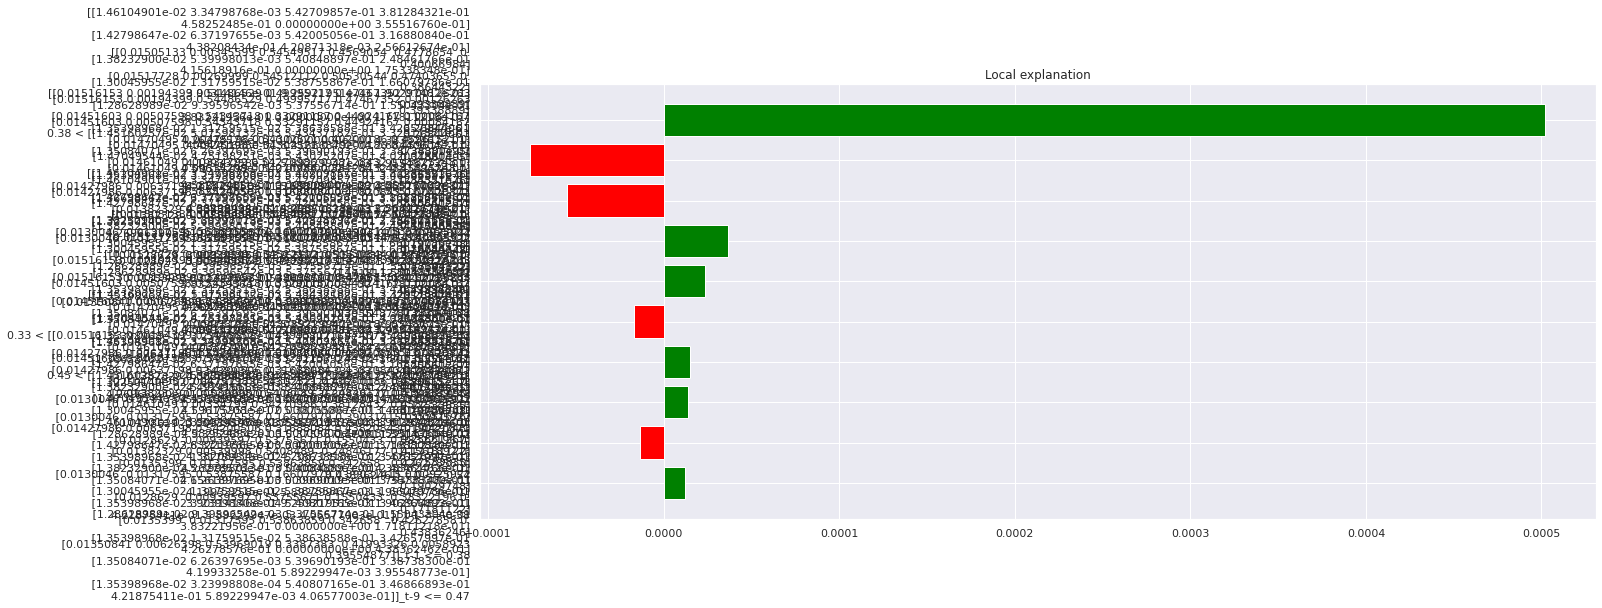

In [17]:
explanations = list(sp_obj.sp_explanations)

#print(len(explanations))

[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]